### Fraud Detection System using ML

### Step 1: Load and Explore the Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Dataset shape: (284807, 31)
Column names:
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


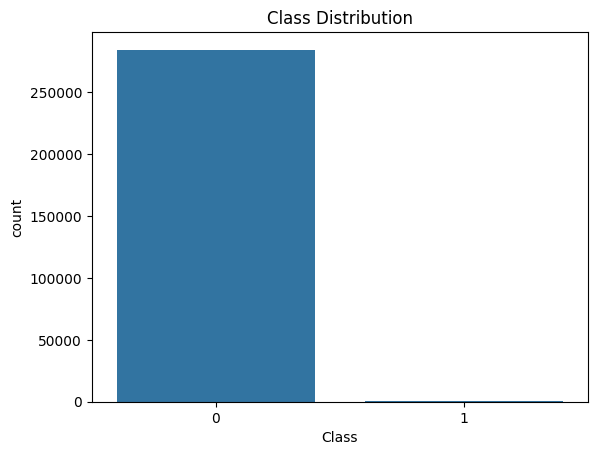

In [3]:
df = pd.read_csv("creditcard.csv")

# Explore dataset
print("Dataset shape:", df.shape)
print("Column names:\n", df.columns)
print("Class distribution:")
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

### Step 2: Feature Engineering

In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Scaling 'Amount' feature
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

# Drop original 'Time' and 'Amount'
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


### Step 3: Train-Test Split and Handling Imbalance

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

# Use SMOTE for balancing
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("After SMOTE: ")
print(pd.Series(y_res).value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

After SMOTE: 
Class
0    284315
1    284315
Name: count, dtype: int64


### Step 4: Train Baseline Model (Random Forest)

In [9]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



### Step 5: Hyperparameter Tuning (Random Forest using RandomizedSearchCV)

In [17]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

print("Best parameters:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best))


Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



### Step 6: Evaluation Metrics

Precision: 0.9997893702169487
Recall: 1.0
F1 Score: 0.9998946740160798
AUC-ROC: 0.9998943029278089


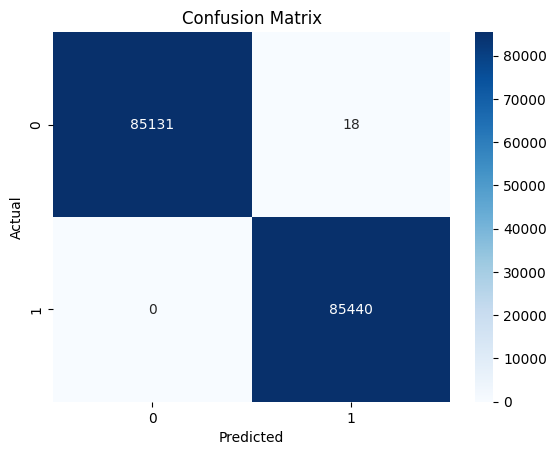

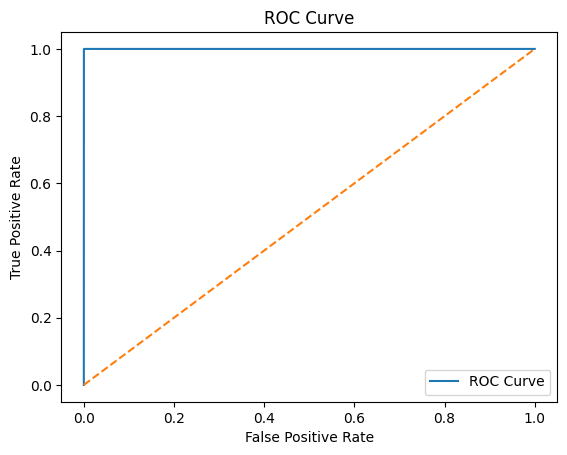

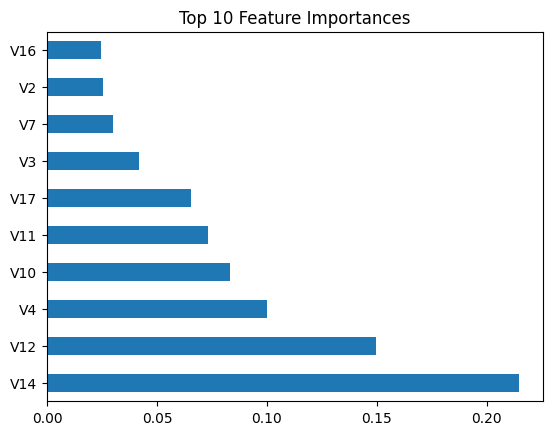

In [19]:
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_best))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Feature Importances
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

### Bonus: Anomaly Detection - Isolation Forest

In [21]:
iso_forest = IsolationForest(contamination=0.001, random_state=42)
y_pred_iso = iso_forest.fit_predict(X)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]  # Convert -1 (anomaly) to 1 (fraud)

print("Isolation Forest Classification Report:")
print(classification_report(y, y_pred_iso))

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.36      0.21      0.27       492

    accuracy                           1.00    284807
   macro avg       0.68      0.61      0.63    284807
weighted avg       1.00      1.00      1.00    284807



### Bonus: Anomaly Detection - Autoencoder

In [35]:
# Use only non-fraud samples for training autoencoder
X_auto = df[df['Class'] == 0].drop('Class', axis=1)
X_fraud = df[df['Class'] == 1].drop('Class', axis=1)

# Normalize
scaler_ae = MinMaxScaler()
X_auto_scaled = scaler_ae.fit_transform(X_auto)
X_fraud_scaled = scaler_ae.transform(X_fraud)

# Autoencoder model
input_dim = X_auto_scaled.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(1e-4))(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_auto_scaled, X_auto_scaled, epochs=10, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)

# Reconstruction error
reconstructions = autoencoder.predict(X_auto_scaled)
mse = np.mean(np.power(X_auto_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
print("Reconstruction error threshold:", threshold)

# Test on fraud samples
fraud_reconstructions = autoencoder.predict(X_fraud_scaled)
mse_fraud = np.mean(np.power(X_fraud_scaled - fraud_reconstructions, 2), axis=1)
y_pred_ae = [1 if e > threshold else 0 for e in mse_fraud]

print("Autoencoder Detection Report (on actual frauds):")
print(classification_report(np.ones(len(y_pred_ae)), y_pred_ae))


Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0143 - val_loss: 0.0016
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0011 - val_loss: 8.5011e-04
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 6.8085e-04 - val_loss: 6.5796e-04
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 5.3827e-04 - val_loss: 5.5931e-04
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 4.6669e-04 - val_loss: 5.0733e-04
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 4.2906e-04 - val_loss: 4.8397e-04
Epoch 7/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 4.0464e-04 - val_loss: 4.4882e-04
Epoch 8/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 3.8681e-04 - val_loss: 4.4346e-04
Epoch 9/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.7330e-04 - val_loss: 4.0809e-04
Epoch 10/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.6694e-04 - val_loss: 4.2989e-04
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 6s 688us/s

C:\Users\Omen\anaconda3\envs\inenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Omen\anaconda3\envs\inenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Omen\anaconda3\envs\inenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
